In [3]:
%matplotlib inline

from __future__ import print_function

import sys
import os
import logging
from logging.config import dictConfig
import numpy as np
import pandas as pd
import itertools as it
import collections as cl
import bisect

from numba import jit

logging_config = dict(
    version = 1,
    formatters = {
        'f': {'format':
              '%(asctime)s %(name)-12s %(levelname)-8s %(message)s'}
        },
    handlers = {
        'h': {'class': 'logging.StreamHandler',
              'formatter': 'f',
              'level': logging.DEBUG}
        },
    root = {
        'handlers': ['h'],
        'level': logging.DEBUG,
        },
)
dictConfig(logging_config)

In [2]:
logger_nb = logging.getLogger('notebook')
logger_nb.info('hello')

2017-06-28 22:46:35,639 notebook     INFO     hello


In [4]:
read_dir='/oak/stanford/groups/mrivas/public_data/nanopore-wgs-consortium/rel3/hg19/chr20'
hap_basename='rel3.chr20.12500.10k-chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10.hap.head'
hap_f='{}/{}'.format(read_dir, hap_basename)

data_dir='/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data'

block_tsv_f='{}/{}'.format(
    data_dir,
    'chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-block-stronglow050-stronghigh083-infofrac10.tsv'
)

prior_count_dir='{}/{}'.format(data_dir, 'prior_count')
log_likelihood_dir='{}/{}/{}'.format(data_dir, 'log_likelihood', hap_basename[:-4])
if not os.path.exists(log_likelihood_dir):
    os.makedirs(log_likelihood_dir)

In [5]:
def read_prior_cnts(block_df, prior_count_dir):
    
    logger_cnt = logging.getLogger('read_prior_cnts')    
    logger_cnt.info(
        'reading prior counts from {}'.format(prior_count_dir)
    )        
    
    prior_cnt_keys = [None] * len(block_df)
    prior_cnt_vals = [None] * len(block_df)
    for block_id in range(len(block_df)):
        if(block_id % 100 == 0):
            logger_cnt.info(
                'reading block {} of {}'.format(block_id, len(block_df))
            )    
        cnt = np.load('{}/{}.npz'.format(prior_count_dir, block_id))
        prior_cnt_keys[block_id] = cnt['keys']
        prior_cnt_vals[block_id] = cnt['vals']
        
    logger_cnt.info(
        'prior counts is loaded on memory'
    )    
        
    return prior_cnt_keys, prior_cnt_vals

In [6]:
def find_block_intervals_from_hap(block_df, hapStart, hapEnd):
    """Align two cordinates (one on read, the other on block_df)"""
    hap_len = hapEnd - hapStart
    hap_to_assign_len = hap_len 
    start_block = bisect.bisect_right(block_df.bimStart.as_matrix(), hapStart) - 1
    current_block = start_block
    
    res = dict([])
    
    while(hap_to_assign_len > 0):
        if(start_block == current_block):
            current_block_SNP_start = hapStart - block_df.bimStart[current_block] 
        else:
            current_block_SNP_start = 0
        if(hap_to_assign_len < block_df.n_SNPs[current_block]):
            current_block_SNP_end = hap_to_assign_len 
            res[current_block] = ((hap_len - hap_to_assign_len, 
                                   hap_len - hap_to_assign_len + current_block_SNP_end - current_block_SNP_start),
                                  (current_block_SNP_start, current_block_SNP_end))
            hap_to_assign_len = 0
        else:
            current_block_SNP_end = block_df.n_SNPs[current_block] 
            res[current_block] = ((hap_len - hap_to_assign_len, 
                                   hap_len - hap_to_assign_len + current_block_SNP_end - current_block_SNP_start),
                                  (current_block_SNP_start, current_block_SNP_end))
            hap_to_assign_len = hap_to_assign_len - (current_block_SNP_end - current_block_SNP_start)  
            current_block = current_block + 1    
    
    return res

def find_ld_blocks(line, block_df):
#     logger_find_ld_blocks = logging.getLogger('find_ld_blocks')    
#     logger_find_ld_blocks.debug('passing {} {}'.format(line[6], line[7]))
    return find_block_intervals_from_hap(block_df, int(line[6]), int(line[7]))

def find_read_specific_error_rate(line):
    return float(line[5])

def find_observation(line):
    obs1d = np.array([1 - int(x) for x in list(line[-1])], dtype=np.int8)
    return obs1d.reshape((1, len(obs1d)))


In [7]:
def compute_likelihood_from_a_read(line, block_df, prior_cnt_keys):
    """Given one line of the input hap file, compute and update the log-likelihood
    """
    
#     logger_read_ll = logging.getLogger('compute_likelihood_from_a_read')
    
    obs = find_observation(line)
    err_rate = find_read_specific_error_rate(line)
    
    likelihood_of_read = dict([])
    
#     logger_read_ll.debug('parsed ld blocks are {}'.format(str(find_ld_blocks(line, block_df))))
    
    for block_id, v in find_ld_blocks(line, block_df).items():
#         logger_read_ll.debug('The LD we are working on is: {} {}'.format(block_id, v))
        
        obs_s, obs_e = v[0]
        block_s, block_e = v[1]    
                
        n_mismatch = np.sum(
            prior_cnt_keys[block_id][:, block_s:block_e] != obs[:, obs_s:obs_e], axis = 1
        )
        n_match = (obs_e - obs_s) - n_mismatch
        
        likelihood_of_read[block_id] = n_mismatch * np.log(err_rate) + n_match * np.log(1 - err_rate)

    return likelihood_of_read

In [8]:
def update_likelihood(likelihood_of_read, log_likelihood):   
    for block_id, ll in likelihood_of_read.items():
        if(block_id in log_likelihood):
            log_likelihood[block_id] = log_likelihood[block_id] + ll
        else:
            log_likelihood[block_id] = ll
    return log_likelihood

In [9]:
def update_ll(hap_f, block_df, prior_cnt_keys, log_likelihood = dict([])):

    logger_ll = logging.getLogger('update_ll')
        
    with open(hap_f, 'r') as f:
        for line_num, raw_line in enumerate(f):
            line  = raw_line.rstrip().split('\t')
            
            if(line_num % 100 == 0):            
                logger_ll.info(
                    'processing read {} {}'.format(line_num, line[3])
                )                                

            likelihood_of_read = compute_likelihood_from_a_read(line, block_df, prior_cnt_keys)            
            log_likelihood = update_likelihood(likelihood_of_read, log_likelihood)
    return log_likelihood

In [10]:
block_df = pd.read_csv(block_tsv_f, sep='\t')

In [11]:
prior_cnt_keys, prior_cnt_vals = read_prior_cnts(block_df, prior_count_dir)

2017-06-28 22:48:17,427 read_prior_cnts INFO     reading prior counts from /oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/prior_count
2017-06-28 22:48:17,431 read_prior_cnts INFO     reading block 0 of 642
2017-06-28 22:48:18,467 read_prior_cnts INFO     reading block 100 of 642
2017-06-28 22:48:19,377 read_prior_cnts INFO     reading block 200 of 642
2017-06-28 22:48:20,562 read_prior_cnts INFO     reading block 300 of 642
2017-06-28 22:48:21,579 read_prior_cnts INFO     reading block 400 of 642
2017-06-28 22:48:22,475 read_prior_cnts INFO     reading block 500 of 642
2017-06-28 22:48:23,238 read_prior_cnts INFO     reading block 600 of 642
2017-06-28 22:48:23,604 read_prior_cnts INFO     prior counts is loaded on memory


In [12]:
log_likelihood = update_ll(hap_f, block_df, prior_cnt_keys)

2017-06-28 22:48:27,191 update_ll    INFO     processing read 0 33ecb953-edd6-445b-87da-85c4551d8c8c_Basecall_Alignment_template


In [13]:
for block_id, ll in log_likelihood.items():
    np.savez(
        '{}/ll{}.npz'.format(log_likelihood_dir, block_id), 
        ll = ll
    )

## draft

In [14]:
log_likelihood

{0: array([-1237.25396363, -1046.37545818, -1295.36326571, ..., -1365.68330601,
        -1191.64300216, -1271.67122066]),
 1: array([-493.04847915, -509.48281659, -525.91715402, ..., -517.6999853 ,
        -525.91715402, -558.7858289 ])}

In [24]:
line

['chr20',
 '59980',
 '65177',
 '33ecb953-edd6-445b-87da-85c4551d8c8c_Basecall_Alignment_template',
 '60',
 '1.442407e-03',
 '0',
 '9',
 '111111101']

In [26]:
def update_likelihood_old(line, log_likelihood, block_df, prior_cnt_keys):
    """Given one line of the input hap file, compute and update the log-likelihood
    """
    obs = find_observation(line)
    err_rate = find_read_specific_error_rate(line)
    for block_id, v in find_ld_blocks(line, block_df).items():
        obs_s, obs_e = v[0]
        block_s, block_e = v[1]    
        n_mismatch = np.sum(
            prior_cnt_keys[block_id][:, block_s:block_e] != obs[obs_s:obs_e], axis = 1
        )
        n_match = (obs_e - obs_s) - n_mismatch
        log_likelihood_of_read = n_mismatch * np.log(err_rate) + n_match * np.log(1 - err_rate)
        if block_id in log_likelihood:
            log_likelihood[block_id] = log_likelihood[block_id] + log_likelihood_of_read
        else:
            log_likelihood[block_id] = log_likelihood_of_read

In [1]:
%matplotlib inline

from __future__ import print_function

import sys
import logging
from logging.config import dictConfig
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools as it
import collections as cl
import multiprocessing
import bisect

from numba import jit

import pgenlib as pg

logging_config = dict(
    version = 1,
    formatters = {
        'f': {'format':
              '%(asctime)s %(name)-12s %(levelname)-8s %(message)s'}
        },
    handlers = {
        'h': {'class': 'logging.StreamHandler',
              'formatter': 'f',
              'level': logging.DEBUG}
        },
    root = {
        'handlers': ['h'],
        'level': logging.DEBUG,
        },
)
dictConfig(logging_config)

In [2]:
logger_nb = logging.getLogger('notebook')
logger_nb.info('hello')

2017-06-28 14:57:10,172 notebook     INFO     hello


In [3]:
data_dir='/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data'
geno_bed_log='chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10.log'
block_log='chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-block-stronglow050-stronghigh083-infofrac10.log'
pgen_log='chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-pg.log'
pgen_f = '{}/{}.pgen'.format(data_dir, pgen_log[:-4])
block_tsv_f = '{}/{}.tsv'.format(data_dir, block_log[:-4])

In [4]:
block_df = pd.read_csv(block_tsv_f, sep='\t')
block_df.head()

,chrom,chromStart,chromEnd,bimStart,bimEnd,nt_size,n_SNPs,n_haps,n_uniq_haps
0,chr20,61097,94951,0,78,33854,78,119900,4833
1,chr20,94951,266791,78,915,171840,837,24264,16646
2,chr20,266791,288775,915,991,21984,76,120130,6487
3,chr20,288775,344630,991,1218,55855,227,70042,16571
4,chr20,344630,346675,1218,1224,2045,6,202090,26


In [9]:
def find_block_intervals_from_hap(block_df, hapStart, hapEnd):
    """Align two cordinates (one on read, the other on block_df)"""
    hap_len = hapEnd - hapStart
    hap_to_assign_len = hap_len 
    start_block = bisect.bisect_right(block_df.bimStart.as_matrix(), hapStart) - 1
    current_block = start_block
    
    res = dict([])
    
    while(hap_to_assign_len > 0):
        if(start_block == current_block):
            current_block_SNP_start = hapStart - block_df.bimStart[current_block] 
        else:
            current_block_SNP_start = 0
        if(hap_to_assign_len < block_df.n_SNPs[current_block]):
            current_block_SNP_end = hap_to_assign_len 
            res[current_block] = ((hap_len - hap_to_assign_len, 
                                   hap_len - hap_to_assign_len + current_block_SNP_end - current_block_SNP_start),
                                  (current_block_SNP_start, current_block_SNP_end))
            hap_to_assign_len = 0
        else:
            current_block_SNP_end = block_df.n_SNPs[current_block] 
            res[current_block] = ((hap_len - hap_to_assign_len, 
                                   hap_len - hap_to_assign_len + current_block_SNP_end - current_block_SNP_start),
                                  (current_block_SNP_start, current_block_SNP_end))
            hap_to_assign_len = hap_to_assign_len - (current_block_SNP_end - current_block_SNP_start)  
            current_block = current_block + 1    
    
    return res

In [10]:
find_block_intervals_from_hap(block_df, 1, 920)

{0: ((0, 77), (1, 78)), 1: ((77, 914), (0, 837)), 2: ((914, 919), (0, 5))}

In [18]:
for k, v in find_block_intervals_from_hap(block_df, 1, 920).items():
    print(k, v)

0 ((0, 77), (1, 78))
1 ((77, 914), (0, 837))
2 ((914, 919), (0, 5))


## read prior counts

In [27]:
prior_cnt_keys = [None] * len(block_df)
prior_cnt_vals = [None] * len(block_df)
for block_id in range(len(block_df)):
    cnt = np.load(
    '/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/prior_count/{}.npz'.format(block_id)
    )
    prior_cnt_keys[block_id] = cnt['keys']
    prior_cnt_vals[block_id] = cnt['vals']

In [26]:
prior_cnt_keys[0].shape, prior_cnt_vals[0].shape, 

((4833, 78), (4833,))

In [11]:
read_dir='/oak/stanford/groups/mrivas/public_data/nanopore-wgs-consortium/rel3/hg19/chr20'
hap_f='{}/rel3.chr20.12500.10k-chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10.hap'.format(read_dir)
# hap_f='{}/rel3.chr20.12500.10k-chr20impv1-keep-maf0005-snv-biallelic.hap'.format(read_dir)

In [12]:
with open(hap_f, 'r') as f:
    line = f.readline().rstrip().split('\t')

In [13]:
line

['chr20',
 '59980',
 '65177',
 '33ecb953-edd6-445b-87da-85c4551d8c8c_Basecall_Alignment_template',
 '60',
 '1.442407e-03',
 '0',
 '9',
 '111111101']

In [15]:
def find_ld_blocks(line, block_df):
    return find_block_intervals_from_hap(block_df, int(line[6]), int(line[7]))

In [16]:
b1 = find_ld_blocks(line, block_df)

In [17]:
b1

{0: ((0, 9), (0, 9))}

In [40]:
print(prior_cnt_keys[0][:, 0:9].shape)
prior_cnt_keys[0][:, 0:9]

(4833, 9)


array([[1, 1, 0, ..., 1, 0, 1],
       [0, 1, 0, ..., 1, 0, 1],
       [1, 1, 0, ..., 1, 0, 1],
       ..., 
       [1, 1, 0, ..., 1, 0, 1],
       [0, 1, 0, ..., 1, 0, 1],
       [1, 1, 0, ..., 1, 0, 1]], dtype=int8)

In [38]:
def find_read_specific_error_rate(line):
    return float(line[5])

In [34]:
def find_observation(line):
    obs1d = np.array([1 - int(x) for x in list(line[-1])], dtype=np.int8)
    return obs1d.reshape((1, len(obs1d)))

In [42]:
obs = find_observation(line)

In [50]:
err_rate = find_read_specific_error_rate(line)

In [46]:
n_mismatch = np.sum(prior_cnt_keys[0][:, 0:9] != obs[0:9], axis = 1)
n_match = (9 - 0) - n_mismatch

In [49]:
np.all(n_mismatch + n_match == 9)

True

In [51]:
np.log(err_rate)

-6.5414420330642029

In [59]:
log_likelihood_of_read = n_mismatch * np.log(err_rate) + n_match * np.log(1 - err_rate)

In [62]:
log_likelihood = dict([])

In [61]:
if 0 in log_likelihood:
    log_likelihood[0] = log_likelihood[0] + log_likelihood_of_read
else:
    log_likelihood[0] = log_likelihood_of_read

In [72]:
def update_likelihood(line, log_likelihood, block_df, prior_cnt_keys):
    """Given one line of the input hap file, compute and update the log-likelihood
    """
    obs = find_observation(line)
    err_rate = find_read_specific_error_rate(line)
    for block_id, v in find_ld_blocks(line, block_df).items():
        obs_s, obs_e = v[0]
        block_s, block_e = v[1]    
        n_mismatch = np.sum(
            prior_cnt_keys[block_id][:, block_s:block_e] != obs[obs_s:obs_e], axis = 1
        )
        n_match = (obs_e - obs_s) - n_mismatch
        log_likelihood_of_read = n_mismatch * np.log(err_rate) + n_match * np.log(1 - err_rate)
        if block_id in log_likelihood:
            log_likelihood[block_id] = log_likelihood[block_id] + log_likelihood_of_read
        else:
            log_likelihood[block_id] = log_likelihood_of_read

In [71]:
log_likelihood[0]

array([-45.79298113, -39.25298254, -45.79298113, ..., -52.33297971,
       -39.25298254, -45.79298113])

In [ ]:
for k, v in log_likelihood.items():
    

In [21]:
cnt0 = np.load(
    '/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/prior_count/0.npz', 
)

In [60]:
cnt0.files

['keys', 'vals']

In [61]:
cnt0['keys'].shape

(5144, 86)

In [62]:
cnt0['vals'].shape

(5144,)

In [66]:
cnt0['keys'][:, 0:9].shape

(5144, 9)

In [76]:
(cnt0['keys'][:, 0:9] != find_observation(line)).shape

(5144, 9)

In [77]:
cnt0['keys'][0, 0:9] != find_observation(line)

array([[False, False, False, False,  True, False, False,  True, False]], dtype=bool)

In [78]:
cnt0['keys'][0, 0:9]

array([1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int8)

In [79]:
find_observation(line)

array([[1, 1, 1, 1, 1, 1, 1, 0, 1]], dtype=int8)

In [81]:
mismatchs = np.sum(cnt0['keys'][:, 0:9] != find_observation(line), axis=1)

(array([    4.,  1766.,  1094.,  1344.,   438.,   284.,   214.,     0.,
            0.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

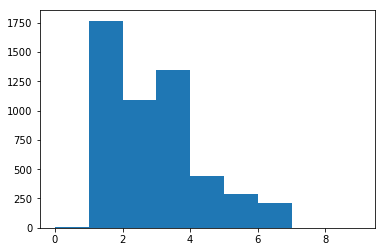

In [85]:
plt.hist(mismatchs, bins=range(0, 10))